# This notebook contains code for obtaining CRC Results:

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
print('Tensorflow version = ',tf.__version__)

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score, precision_score,balanced_accuracy_score,roc_auc_score,roc_curve

import ML_models

Tensorflow version =  2.1.0


# Key parameters: 

In [2]:
#parameter settings
dz = 3

batch_size = 512
ClassWeights1=[1.0,1.0]
ClassWeights2=[1.0,0.25]

Per_spectra_thresh = 0.5
TissueGroupThreshold = 0.5

# Load metadata and preprepared imzML binned data:

In [3]:
metadata_df = pd.read_excel(pd.ExcelFile('../MetaData/TMA clinical data v2 04122018.xlsx'), 'Primary') 
metadata_df=metadata_df.set_index('Primary Patient No')
metadata_df=metadata_df.sort_index()

imzML_df = pd.read_hdf('BinnedData/imzML_dz'+str(dz)+'_df.h5') #number of rows = number of patients
imzML_df = imzML_df.replace(np.nan, '', regex=True)

# Add the number of samples and bins to the dataframe and merge metadata into imzml_df:

In [4]:
for index, row in imzML_df.iterrows():
    if len(row['binned_normal'])>0:
        imzML_df.at[index,'NumNormalSamples']=row['binned_normal'][0].shape[0]
        imzML_df.at[index,'NumNormalBins']=row['binned_normal'][0].shape[1]
    else:
        imzML_df.at[index,'NumNormalSamples']=0
        imzML_df.at[index,'NumNormalBins']=0
    if len(row['binned_tumour'])>0:
        imzML_df.at[index,'NumTumourSamples']=row['binned_tumour'][0].shape[0]
        imzML_df.at[index,'NumTumourBins']=row['binned_tumour'][0].shape[1]
    else:
        imzML_df.at[index,'NumTumourSamples']=0
        imzML_df.at[index,'NumTumourBins']=0
imzML_df['NumNormalSamples']=imzML_df['NumNormalSamples'].astype('int')
imzML_df['NumNormalBins']=imzML_df['NumNormalBins'].astype('int')
imzML_df['NumTumourSamples']=imzML_df['NumTumourSamples'].astype('int')
imzML_df['NumTumourBins']=imzML_df['NumTumourBins'].astype('int')
imzML_df.insert(0,'NormalSig',np.zeros(imzML_df.shape[0]))
imzML_df.insert(1,'TumourSig',np.zeros(imzML_df.shape[0]))

metadata_df.index = metadata_df.index.map(str)
imzML_df = pd.concat([imzML_df,metadata_df], axis=1, sort=True)
imzML_df = imzML_df[imzML_df['TMA_ID'].notna()] #drop rows for which we have no TMA

print('Total patients = ',imzML_df.shape[0],'; Total spectra = ',int(imzML_df['NumNormalSamples'].sum()+imzML_df['NumTumourSamples'].sum()))


Total patients =  302 ; Total spectra =  188515


# Functions for creating train and validation splits:

In [5]:
#this function converts all patient data to be used for training to a numpy array:
def CreateTrainArrays(The_df):
    X_data0 = []
    X_data1 = []
    for patient in range(The_df.shape[0]):
        if isinstance(The_df['binned_normal'].values[patient],str) == False:
            if len(The_df['binned_normal'].values[patient])!=0:
                X_data0.append(The_df['binned_normal'].values[patient][0])
        if isinstance(The_df['binned_tumour'].values[patient],str) == False:
            if  len(The_df['binned_tumour'].values[patient])!=0:
                X_data1.append(The_df['binned_tumour'].values[patient][0])
    X_data0 = np.concatenate(X_data0,axis=0)
    X_data1 = np.concatenate(X_data1,axis=0)
    X = np.concatenate((X_data0,X_data1),axis=0)
    Y = np.squeeze(np.concatenate((np.zeros((X_data0.shape[0],1),'uint8'),np.ones((X_data1.shape[0],1),'uint8')),axis=0))
    return X,Y
#this function converts all patient data to be used for validation to a numpy array:
def CreateValArrays(The_df,Which):
    X_data = []
    for patient in range(The_df.shape[0]):
        if isinstance(The_df[Which].values[patient],str) == False:
            if len(The_df[Which].values[patient])!=0:
                X_data.append(The_df[Which].values[patient][0])
    if len(X_data)>0:
        X_data = np.concatenate(X_data,axis=0)
    else:
        X_data=X_data[0]
    return X_data

# Loop over each LOO split and train models:

In [6]:
#step 3: train models - we are using an ensemble of two models for each fold
UniqueTMAs = imzML_df['TMA_ID'].unique()
CrossValidationModels1=[]
CrossValidationModels2=[]
for ID in UniqueTMAs:
    start = time.time()
    #filter the data to training and validation spltis
    Train_df = imzML_df[imzML_df['TMA_ID']!=ID]
    Val_df = imzML_df[imzML_df['TMA_ID']==ID]
    #convert from dataframes to numpy
    X_train,y_train = CreateTrainArrays(Train_df)
    X_val,y_val = CreateTrainArrays(Val_df)
    #apply sqrt of data
    X_train = np.sqrt(X_train)
    X_val = np.sqrt(X_val)
    #create and train the models:
    #1d conv net
    model1 = ML_models_Jan2021.ConvNet_1D(X_train,y_train,X_val,y_val,batch_size,ClassWeights1)
    CrossValidationModels1.append(model1)
    #MLP
    model2 = ML_models_Jan2021.NeuralNetwork(X_train,y_train,X_val,y_val,batch_size,ClassWeights2)
    CrossValidationModels2.append(model2)
    print('train time = ',time.time() - start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 172311 samples, validate on 16204 samples
Epoch 1/5
172311/172311 [==============================] - 15s 87us/sample - loss: 0.6376 - accuracy: 0.8983 - val_loss: 0.5299 - val_accuracy: 0.8430
Epoch 2/5
172311/172311 [==============================] - 8s 49us/sample - loss: 0.2912 - accuracy: 0.9403 - val_loss: 0.3219 - val_accuracy: 0.8955
Epoch 3/5
172311/172311 [==============================] - 8s 49us/sample - loss: 0.2158 - accuracy: 0.9440 - val_loss: 0.3370 - val_accuracy: 0.8835
Epoch 4/5
172311/172311 [==============================] - 8s 49us/sample - loss: 0.1983 - accuracy: 0.9447 - val_loss: 0.2768 - val_accuracy: 0.9072
Epoch 5/5
172311/172311 [==============================] - 9s 53us/sample - loss: 0.1875 - accuracy: 0.9468 - val_loss: 0.6029 - val_accuracy: 0.7281
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 172311 samples, validate on 16204 samples
Epoch 6/10
172311/172311 [=====================

177975/177975 [==============================] - 15s 82us/sample - loss: 0.0980 - accuracy: 0.9736 - val_loss: 0.1805 - val_accuracy: 0.9387
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 177975 samples, validate on 10540 samples
Epoch 25/25
177975/177975 [==============================] - 2s 12us/sample - loss: 0.0543 - accuracy: 0.9398 - val_loss: 0.0628 - val_accuracy: 0.9307
train time =  186.5361578464508
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 175613 samples, validate on 12902 samples
Epoch 1/5
175613/175613 [==============================] - 16s 89us/sample - loss: 0.6427 - accuracy: 0.8922 - val_loss: 0.5864 - val_accuracy: 0.8441
Epoch 2/5
175613/175613 [==============================] - 9s 53us/sample - loss: 0.2895 - accuracy: 0.9393 - val_loss: 0.3484 - val_accuracy: 0.8901
Epoch 3/5
175613/175613 [==============================] - 9s 53us/sampl

173742/173742 [==============================] - 21s 118us/sample - loss: 0.1523 - accuracy: 0.9601 - val_loss: 0.2590 - val_accuracy: 0.9171
Epoch 7/10
173742/173742 [==============================] - 16s 94us/sample - loss: 0.1362 - accuracy: 0.9640 - val_loss: 0.2255 - val_accuracy: 0.9279
Epoch 8/10
173742/173742 [==============================] - 16s 94us/sample - loss: 0.1263 - accuracy: 0.9665 - val_loss: 0.2556 - val_accuracy: 0.9136
Epoch 9/10
173742/173742 [==============================] - 16s 95us/sample - loss: 0.1194 - accuracy: 0.9673 - val_loss: 0.2890 - val_accuracy: 0.9022
Epoch 10/10
173742/173742 [==============================] - 16s 94us/sample - loss: 0.1137 - accuracy: 0.9680 - val_loss: 0.2618 - val_accuracy: 0.9123
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 173742 samples, validate on 14773 samples
Epoch 11/11
173742/173742 [==============================] - 20s 115us/sample - loss: 0.1001 - accuracy: 0.9736 - val_loss: 0.2758 - val_accuracy: 0

176400/176400 [==============================] - 22s 126us/sample - loss: 0.6320 - accuracy: 0.8985 - val_loss: 0.5231 - val_accuracy: 0.8452
Epoch 2/5
176400/176400 [==============================] - 17s 94us/sample - loss: 0.2890 - accuracy: 0.9383 - val_loss: 0.4070 - val_accuracy: 0.8739
Epoch 3/5
176400/176400 [==============================] - 17s 94us/sample - loss: 0.2190 - accuracy: 0.9409 - val_loss: 0.3743 - val_accuracy: 0.8562
Epoch 4/5
176400/176400 [==============================] - 17s 95us/sample - loss: 0.1968 - accuracy: 0.9442 - val_loss: 0.2469 - val_accuracy: 0.9315
Epoch 5/5
176400/176400 [==============================] - 17s 95us/sample - loss: 0.1911 - accuracy: 0.9453 - val_loss: 0.2174 - val_accuracy: 0.9378
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 176400 samples, validate on 12115 samples
Epoch 6/10
176400/176400 [==============================] - 20s 113us/sample - loss: 0.1486 - accuracy: 0.9607 - val_loss: 0.1993 - val_accuracy: 0.9339


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 174358 samples, validate on 14157 samples
Epoch 25/25
174358/174358 [==============================] - 3s 17us/sample - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.0429 - val_accuracy: 0.9476
train time =  275.0247714519501
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 176284 samples, validate on 12231 samples
Epoch 1/5
176284/176284 [==============================] - 21s 119us/sample - loss: 0.6821 - accuracy: 0.8747 - val_loss: 0.4597 - val_accuracy: 0.8864
Epoch 2/5
176284/176284 [==============================] - 17s 95us/sample - loss: 0.3004 - accuracy: 0.9358 - val_loss: 0.2856 - val_accuracy: 0.9195
Epoch 3/5
176284/176284 [==============================] - 17s 94us/sample - loss: 0.2259 - accuracy: 0.9391 - val_loss: 0.3735 - val_accuracy: 0.8569
Epoch 4/5
176284/176284 [==============================] - 17s 95us/sample - loss: 0.

Epoch 8/10
181536/181536 [==============================] - 11s 59us/sample - loss: 0.1271 - accuracy: 0.9644 - val_loss: 0.2378 - val_accuracy: 0.9620
Epoch 9/10
181536/181536 [==============================] - 11s 58us/sample - loss: 0.1202 - accuracy: 0.9658 - val_loss: 0.2228 - val_accuracy: 0.9603
Epoch 10/10
181536/181536 [==============================] - 11s 59us/sample - loss: 0.1154 - accuracy: 0.9666 - val_loss: 0.2225 - val_accuracy: 0.9574
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 181536 samples, validate on 6979 samples
Epoch 11/11
181536/181536 [==============================] - 19s 103us/sample - loss: 0.1008 - accuracy: 0.9723 - val_loss: 0.2706 - val_accuracy: 0.9615
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 181536 samples, validate on 6979 samples
Epoch 25/25
181536/181536 [==============================] - 2s 12us/sample - loss: 0.053

# Run validation for each model for each TMA:

In [7]:
AllPredictions1=[]
AllPredictions2=[]
CC=0
for ID in UniqueTMAs:
    Val_df = imzML_df[imzML_df['TMA_ID']==ID]
    X_val,y_val = CreateTrainArrays(Val_df)
    X_val = np.sqrt(X_val)
    #run the models for this TMA
    model = CrossValidationModels1[CC]
    raw_pred = model.predict(np.expand_dims(X_val,-1))
    AllPredictions1.append(raw_pred)
    model = CrossValidationModels2[CC]
    raw_pred = model.predict(X_val)
    AllPredictions2.append(raw_pred)
    CC+=1

# Results for classification of spectra:

In [8]:
Accs=[]
BalAccs=[]
Sens=[]
Specs=[]
AUCs=[]
AUC_tprs =[]
AUC_fprs =[]
AUC_thresholds =[]
CC=0
for ID in UniqueTMAs:
    Val_df = imzML_df[imzML_df['TMA_ID']==ID]
    _,y_val = CreateTrainArrays(Val_df)
    #average the model predictions
    raw_pred=np.squeeze(AllPredictions1[CC])/2+np.squeeze(AllPredictions2[CC])/2
 
    ###########################################################################################
    #get TPR v TNR curve
    ###########################################################################################
    fpr, tpr, thresholds = roc_curve(y_val, raw_pred)
    AUC_tprs.append(tpr)
    AUC_fprs.append(fpr)
    AUC_thresholds.append(thresholds)
    
    ###########################################################################################
    #get per-spectra metrics
    ###########################################################################################
    y_pred = (raw_pred>Per_spectra_thresh).astype('uint8')

    Overall_accuracy = accuracy_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val,y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    AUC = roc_auc_score(y_val, raw_pred)
    
    Accs.append(Overall_accuracy)
    BalAccs.append(Balanced_accuracy)
    Sens.append(Sensitivity)
    Specs.append(Specificity)
    AUCs.append(AUC)

    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))
    CC+=1
plt.show()

Confusion Matrix: 
[[ 4514   168]
 [ 1248 10274]]
Validation Accuracy: 91.26%
Validation Sensitivity: 89.17%
Validation Specificity: 96.41%
Validation Balanced accuracy: 92.79%
Validation AUC: 0.9852
Confusion Matrix: 
[[4060  376]
 [ 556 9030]]
Validation Accuracy: 93.35%
Validation Sensitivity: 94.20%
Validation Specificity: 91.52%
Validation Balanced accuracy: 92.86%
Validation AUC: 0.9843
Confusion Matrix: 
[[3303  136]
 [ 461 6640]]
Validation Accuracy: 94.34%
Validation Sensitivity: 93.51%
Validation Specificity: 96.05%
Validation Balanced accuracy: 94.78%
Validation AUC: 0.9918
Confusion Matrix: 
[[4088  455]
 [ 143 8216]]
Validation Accuracy: 95.37%
Validation Sensitivity: 98.29%
Validation Specificity: 89.98%
Validation Balanced accuracy: 94.14%
Validation AUC: 0.9924
Confusion Matrix: 
[[ 5177   284]
 [  472 10072]]
Validation Accuracy: 95.28%
Validation Sensitivity: 95.52%
Validation Specificity: 94.80%
Validation Balanced accuracy: 95.16%
Validation AUC: 0.9887
Confusion Ma

# Print average metrics:

In [9]:
print('Average accuracy: ',np.mean(Accs))
print('Average balanced accuracy: ',np.mean(BalAccs))
print('Average sensitivity: ',np.mean(Sens))
print('Average specificity: ',np.mean(Specs))
print('Average AUC: ',np.mean(AUCs))
min(AUCs),max(AUCs)

Average accuracy:  0.9412558952020598
Average balanced accuracy:  0.9408430724169089
Average sensitivity:  0.9423034311111621
Average specificity:  0.9393827137226556
Average AUC:  0.9863923921055476


(0.9652348649122136, 0.9970518573266601)

# Figure for TPR v TNR:

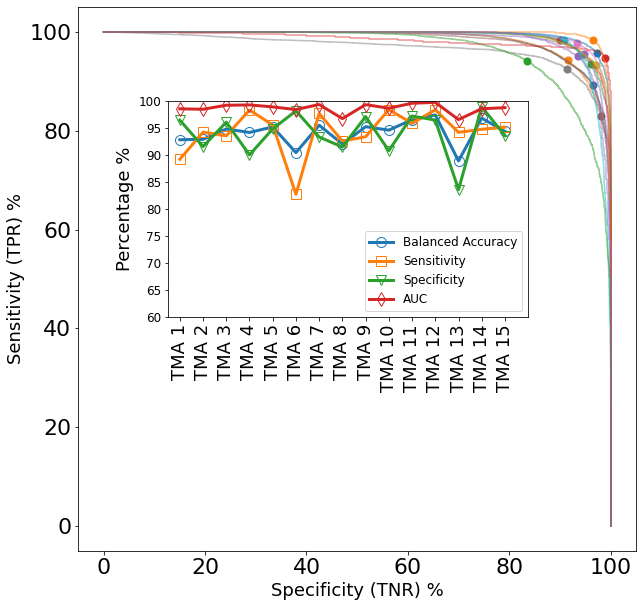

In [10]:
matplotlib.rcParams.update({'font.size': 22})
AnonymisedUniqueTMAs = ['TMA '+str(i+1) for i in range(len(UniqueTMAs))]
plt.figure(figsize=(10,10))
for j in range(len(AUC_tprs)):
    plt.plot(100.0-100*AUC_fprs[j],100*AUC_tprs[j],alpha=0.5)
    #find fpr and tpr for threshold Per_spectra_thresh
    ind = min(range(len(AUC_thresholds[j])), key=lambda i: abs(AUC_thresholds[j][i]-Per_spectra_thresh))
    plt.scatter(100-100*AUC_fprs[j][ind],100*AUC_tprs[j][ind],s=50,marker='o')
    plt.ylabel('Sensitivity (TPR) %',fontsize=18)
plt.xlabel('Specificity (TNR) %',fontsize=18)

matplotlib.rcParams.update({'font.size': 12})
a = plt.axes([.25, .45, .5, .3])
plt.plot(100*np.array(BalAccs),'-o',markersize=10, label='Balanced Accuracy',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(Sens),'-s',markersize=10, label='Sensitivity',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(Specs),'-v',markersize=10, label='Specificity',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(AUCs),'-d',markersize=10, label='AUC',markerfacecolor='none',linewidth=3)
plt.xlim((-0.5,15))
plt.ylim((60,100))
plt.xticks(np.arange(15),AnonymisedUniqueTMAs,rotation='vertical',fontsize=18)
plt.ylabel('Percentage %',fontsize=18)
plt.legend(loc='lower right')
plt.savefig('Figures/Experiment1.pdf')
plt.show()

# Results for per-patient tissue groups in the validation set:

In [11]:
ValPatientCounts=[]
ValPatientCorrectCounts=[]
ValPatientAccs=[]
PatientConfusionMatrix=np.zeros((2,2),dtype='uint16')
CC=0
for ID in UniqueTMAs:
    Val_df = imzML_df[imzML_df['TMA_ID']==ID]
    model1 = CrossValidationModels1[CC]
    model2 = CrossValidationModels2[CC]
    TissueGroupCountCorrect = 0
    TissueGroupCount = 0
    for patient_id in range(Val_df.shape[0]):
        ThisPatient=Val_df[Val_df.index==Val_df.index[patient_id]]
        #normal spectra:
        if ThisPatient['NumNormalSamples'].values[0]>0:
            TissueGroupCount=TissueGroupCount+1
            X_val = CreateValArrays(ThisPatient,'binned_normal')
            X_val=np.sqrt(X_val)
            raw_pred=model1.predict(np.expand_dims(X_val,-1))[:,0]/2+np.squeeze(model2.predict(X_val))/2
            NormalSig = np.median(raw_pred)
            if NormalSig<TissueGroupThreshold:
                TissueGroupCountCorrect=TissueGroupCountCorrect+1
                PatientConfusionMatrix[0,0] += 1
            else:
                PatientConfusionMatrix[0,1]+=1
            imzML_df.at[ThisPatient.index,'NormalSig']=NormalSig
        else:
            #no data
            imzML_df.at[ThisPatient.index,'NormalSig']=-1
        #tumour spectra:
        if ThisPatient['NumTumourSamples'].values[0]>0:
            TissueGroupCount=TissueGroupCount+1
            X_val = CreateValArrays(ThisPatient,'binned_tumour')
            X_val=np.sqrt(X_val)
            raw_pred=model1.predict(np.expand_dims(X_val,-1))[:,0]/2+np.squeeze(model2.predict(X_val))/2
            TumourSig = np.median(raw_pred)
            if TumourSig>TissueGroupThreshold:
                TissueGroupCountCorrect=TissueGroupCountCorrect+1
                PatientConfusionMatrix[1,1] += 1
            else:
                PatientConfusionMatrix[1,0] += 1
            imzML_df.at[ThisPatient.index,'TumourSig']=TumourSig
        else:
            #no data
            imzML_df.at[ThisPatient.index,'TumourSig']=-1
    print('Accuracy in group = ',TissueGroupCountCorrect/TissueGroupCount)
    ValPatientCounts.append(TissueGroupCount)
    ValPatientCorrectCounts.append(TissueGroupCountCorrect)
    ValPatientAccs.append(TissueGroupCountCorrect/TissueGroupCount)
    CC+=1


Accuracy in group =  0.9761904761904762
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  0.9534883720930233
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  0.9743589743589743
Accuracy in group =  1.0
Accuracy in group =  1.0
Accuracy in group =  0.9523809523809523
Accuracy in group =  0.9523809523809523
Accuracy in group =  1.0


# Get accuracy for tumour and normal separately, overall (not by TMA):

In [12]:
aa = imzML_df[imzML_df['TumourSig']>0]
Sensitivity= sum(aa['TumourSig'].values>TissueGroupThreshold)/aa['TumourSig'].shape[0]
aa = imzML_df[imzML_df['NormalSig']>0]
Specificity= sum(aa['NormalSig'].values<TissueGroupThreshold)/aa['NormalSig'].shape[0]
Sensitivity,Specificity

(0.9856115107913669, 0.9895104895104895)

# Overall sensitivity and specificity by TMA:

In [13]:
ValPatientAccsNormal=[]
ValPatientAccsTumour=[]
for ID in UniqueTMAs:
    Val_df = imzML_df[imzML_df['TMA_ID']==ID]
    aa = Val_df[Val_df['TumourSig']>0]
    Sensitivity_TMA= sum(aa['TumourSig'].values>TissueGroupThreshold)/aa['TumourSig'].shape[0]
    ValPatientAccsTumour.append(Sensitivity)
    aa = Val_df[Val_df['NormalSig']>0]
    Specificity_TMA= sum(aa['NormalSig'].values<TissueGroupThreshold)/aa['NormalSig'].shape[0]
    ValPatientAccsNormal.append(Specificity)
    print(Sensitivity_TMA,Specificity_TMA)

0.95 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.9090909090909091 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.9473684210526315
1.0 1.0
1.0 1.0
1.0 0.9047619047619048
0.9090909090909091 1.0
1.0 1.0


# Final Figures:

564 557 0.9872533151602919
[[283   3]
 [  4 274]]
False positives =  3
False negatives =  4


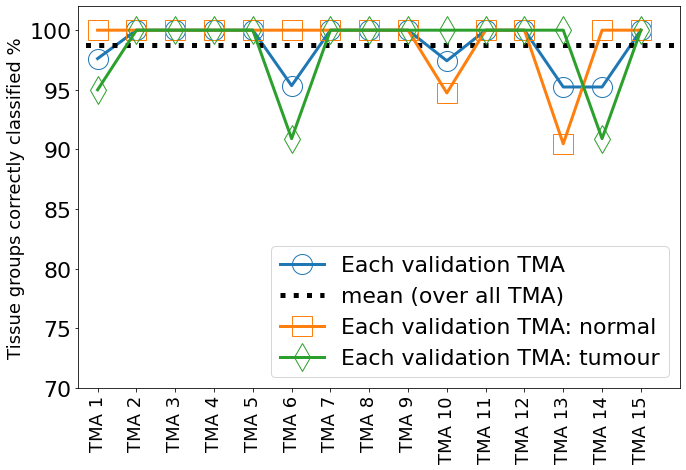

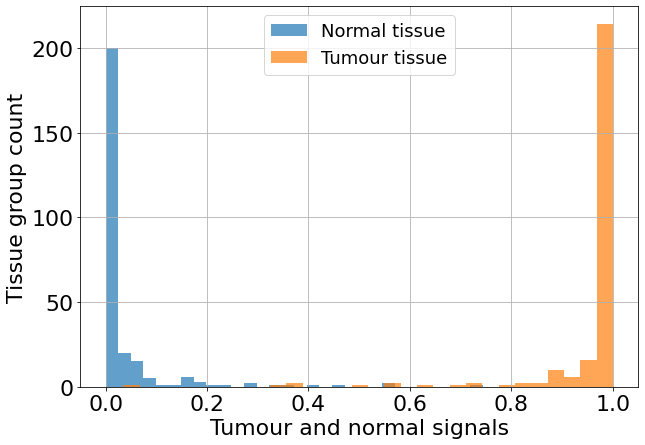

In [14]:
print(sum(ValPatientCounts),sum(ValPatientCorrectCounts),np.mean(ValPatientAccs))
print(PatientConfusionMatrix)
print('False positives = ',PatientConfusionMatrix[0,1])
print('False negatives = ',PatientConfusionMatrix[1,0])

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,7))
plt.plot(100*np.array(ValPatientAccs),'-o',markersize=20, label='Each validation TMA',markerfacecolor='none',linewidth=3)
plt.plot(np.arange(-1,16),100*np.mean(ValPatientAccs)*np.ones(17),'black', linestyle=':',label='mean (over all TMA)',linewidth=5)
plt.plot(100*np.array(ValPatientAccsNormal),'-s',markersize=20, label='Each validation TMA: normal',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(ValPatientAccsTumour),'-d',markersize=20, label='Each validation TMA: tumour',markerfacecolor='none',linewidth=3)
plt.xlim((-0.5,15))
plt.ylim((70,102))
plt.xticks(np.arange(15),AnonymisedUniqueTMAs,rotation='vertical',fontsize=18)
plt.ylabel('Tissue groups correctly classified %',fontsize=18)
plt.legend(loc="lower right")
plt.tight_layout() #need this or xticks get cut off in eps file
plt.savefig('Figures/Experiment2a.pdf')
plt.show()

#plot histograms of the ML based signal for normal tissue and tumour tissue
aa = imzML_df[imzML_df['NormalSig']>0] # filter to cases  where we have both normal and tumour
aa = aa[aa['TumourSig']>0] # filter to cases  where we have both normal and tumour

fig = plt.figure(figsize = (10,7))
ax = fig.gca()
aa['NormalSig'].hist(ax=ax,bins=30,alpha=0.7,label='Normal tissue')
aa['TumourSig'].hist(ax=ax,bins=30,alpha=0.7,label='Tumour tissue')
plt.xlabel('Tumour and normal signals')
plt.ylabel('Tissue group count')
plt.legend(loc="upper center",fontsize=18)
fig.gca().set_rasterized(True)
plt.savefig('Figures/Experiment2b.pdf')
plt.show()
